# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [83]:
%run -i 'cosim_import.py'

0.post4476.dev0+g2e7c59d
2.9.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [84]:
caseH = 18
ict_off = False

%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=433.49 MWh
Online 14439, Q=361.0 MWh, SoC=0.7685
Power(MW): Pt=-39.7925, Pc=-39.7925, Pd=-0.0
Ctrl: 0=7733; 1=6706; 
EVA: Load A from Aest.csv.
Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Reloaded generated Python code of module "pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.3899 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1584 seconds.
System internal structure set up in 0.0834 seconds.


In [85]:
np.random.seed(sse.seed)
ict_rid = np.random.randint(low=0,
                            high=sse.ev.shape[0],
                            size=30000)

In [86]:
sse.ev.na.iloc[ict_rid] = sse.ev.nam.iloc[ict_rid]
sse.ev.lc.iloc[ict_rid] = 1
sse.g_u()
sse.g_frc()

[0.002347353960510034, 0.00018305919512324643]

## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


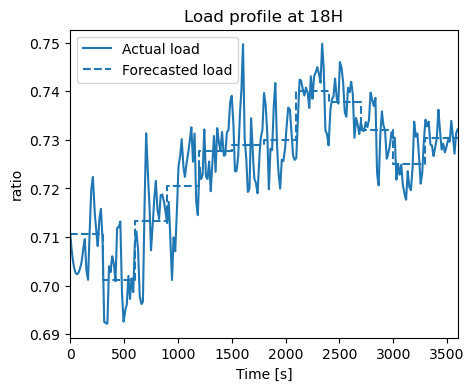

In [87]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [88]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0716 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.917096747
2: |F(x)| = 0.1313034816
3: |F(x)| = 0.0003572030639
4: |F(x)| = 4.286551558e-09
Converged in 5 iterations in 0.0165 seconds.
Power flow results are consistent. Conversion is successful.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0190 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.917096747
2: |F(x)| = 0.1313034816
3: |F(x)| = 0.0003

pp cost=2224.7878007021177, gb cost=4910.261740428772


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,1002.7465,90.1808,15.9216,1.0,1002.7465
1,646.0000,310.9539,1.9541,1.0,646.0000
2,290.0000,148.8148,-1.1566,1.0,290.0000
3,652.0000,129.6589,6.9368,1.0,652.0000
4,508.0000,145.0392,5.1055,1.0,508.0000
5,668.4976,225.0970,6.4635,1.0,668.4977
6,232.0000,60.4674,3.2564,1.0,232.0000
7,564.0000,-26.0145,13.4722,1.0,564.0000
8,865.0000,115.3272,15.9301,1.0,865.0000
9,-39.7925,0.0000,15.9301,1.0,-39.7925


## Prepare

### Make link table

In [89]:
%run -i 'cosim_linktable.py'
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,rexc_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [90]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 400

rru, rrd, rsfr = 1, 0.0, 0.04

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Check convergence

In [91]:
%run -i 'cosim_bmain.py'

RTED removed: ['rampu', 'rampd']


RTED not solved:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
They run into: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Loop

In [92]:
%run -i 'cosim_main.py'

RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4565.434
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0124 seconds.
0: |F(x)| = 7.80582491
1: |F(x)| = 3.742966126
2: |F(x)| = 0.2483180912
3: |F(x)| = 0.002029368999
4: |F(x)| = 9.496969566e-08
Converged in 5 iterations in 0.0115 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for 

Simulation to t=124.00 sec completed in 0.0736 seconds.
Simulation to t=125.00 sec completed in 0.0731 seconds.
Simulation to t=126.00 sec completed in 0.0725 seconds.
Simulation to t=127.00 sec completed in 0.0711 seconds.
Simulation to t=128.00 sec completed in 0.0719 seconds.
Simulation to t=129.00 sec completed in 0.0746 seconds.
Simulation to t=130.00 sec completed in 0.0728 seconds.
Simulation to t=131.00 sec completed in 0.0780 seconds.
Simulation to t=132.00 sec completed in 0.0764 seconds.
Simulation to t=133.00 sec completed in 0.0758 seconds.
Simulation to t=134.00 sec completed in 0.0728 seconds.
Simulation to t=135.00 sec completed in 0.0735 seconds.
Simulation to t=136.00 sec completed in 0.0733 seconds.
Simulation to t=137.00 sec completed in 0.0759 seconds.
Simulation to t=138.00 sec completed in 0.0705 seconds.
Simulation to t=139.00 sec completed in 0.0735 seconds.
Simulation to t=140.00 sec completed in 0.0730 seconds.
Simulation to t=141.00 sec completed in 0.0737 s

Simulation to t=271.00 sec completed in 0.1043 seconds.
Simulation to t=272.00 sec completed in 0.0682 seconds.
Simulation to t=273.00 sec completed in 0.0689 seconds.
Simulation to t=274.00 sec completed in 0.0716 seconds.
Simulation to t=275.00 sec completed in 0.0741 seconds.
Simulation to t=276.00 sec completed in 0.0696 seconds.
Simulation to t=277.00 sec completed in 0.0699 seconds.
Simulation to t=278.00 sec completed in 0.0695 seconds.
Simulation to t=279.00 sec completed in 0.0712 seconds.
Simulation to t=280.00 sec completed in 0.0722 seconds.
Simulation to t=281.00 sec completed in 0.0699 seconds.
Simulation to t=282.00 sec completed in 0.0709 seconds.
Simulation to t=283.00 sec completed in 0.0771 seconds.
Simulation to t=284.00 sec completed in 0.0857 seconds.
Simulation to t=285.00 sec completed in 0.0753 seconds.
Simulation to t=286.00 sec completed in 0.0786 seconds.
Simulation to t=287.00 sec completed in 0.0839 seconds.
Simulation to t=288.00 sec completed in 0.0773 s

In [93]:
ssa.exit_code

0

In [94]:
sse.g_frc()

[2.2566095748696604, 0.716049233147338]

In [95]:
sse.ev[sse.ev.na >= sse.ev.nam]

,u,u0,soc,bd,c,c2,c0,sx,dP,xl,...,Q,ts,tf,tt,pref,lc,agc,mod,na,nam
0,1,1,0.649117,0,1,0,0,12,4.517338,"[[], [], []]",...,27.430770,15.463769,22.737395,0.458712,0,1.0,0,0,2744,2744
1,1,1,0.679315,0,1,0,0,13,5.326607,"[[], [], []]",...,27.565055,16.133211,22.941190,0.498834,0,1.0,0,0,2456,2456
3,0,0,0.379217,0,0,1,1,7,0.000000,"[[], [], []]",...,29.049081,18.929042,23.588663,0.536130,0,1.0,0,0,2395,1997
4,1,1,0.384569,0,1,0,0,7,5.699224,"[[], [], []]",...,27.018238,17.803429,23.370086,0.508313,0,1.0,0,0,2465,2465
5,0,0,0.330185,0,0,1,1,6,0.000000,"[[], [], []]",...,22.566681,18.968916,23.595366,0.512731,0,1.0,0,0,3431,3033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17327,1,1,0.364012,0,1,0,0,7,5.407903,"[[], [], []]",...,23.949749,17.813362,23.372266,0.498703,0,1.0,0,0,2930,2930
17328,1,1,0.566083,0,1,0,0,11,5.025165,"[[], [], []]",...,24.353647,16.623537,23.079570,0.482705,0,1.0,0,0,2973,2973
17329,1,1,1.000000,1,0,1,1,19,0.000000,"[[], [], []]",...,21.754871,14.540077,22.433634,0.537748,0,1.0,0,0,3009,3009
17330,1,1,0.540821,0,1,0,0,10,5.623561,"[[], [], []]",...,29.013649,16.930811,23.161160,0.505100,0,1.0,0,0,2222,2222


(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [H]', ylabel='Power (MW)'>)

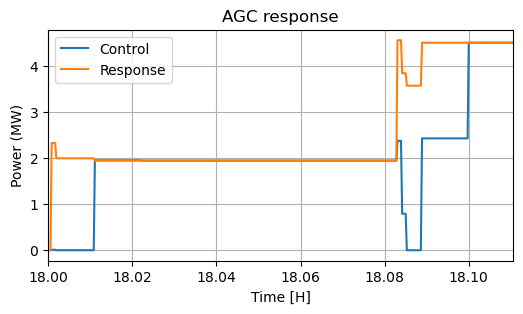

In [96]:
sse.plot_agc()

(<Figure size 600x300 with 2 Axes>,
 <AxesSubplot:title={'center':'EVA'}, xlabel='Time [H]', ylabel='Power (MW)'>)

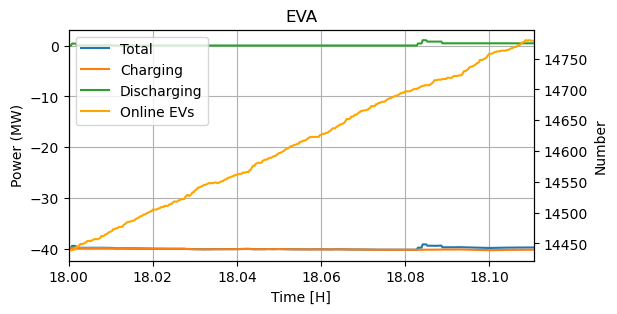

In [97]:
sse.plot()

(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [H]', ylabel='Power (MW)'>)

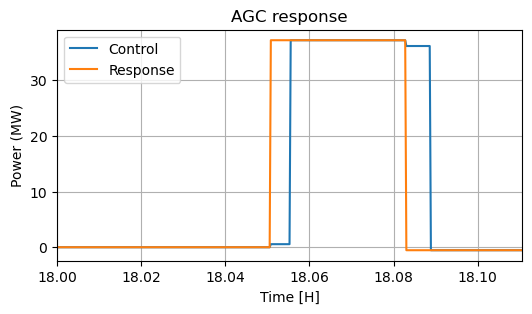

In [70]:
sse.plot_agc()

ValueError: x and y must have same first dimension, but have shapes (49,) and (99,)

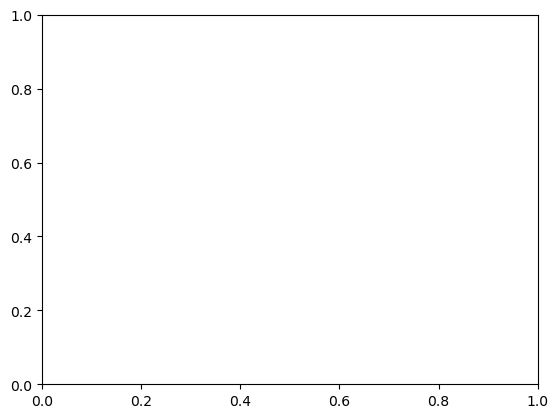

In [71]:
plt.plot(range(49), agc_out.iloc[10].values[2:])

In [ ]:
agc_table.round(4)

In [ ]:
# ssa.TDS.save_output()

In [ ]:
%run -i 'cosim_plot.py'

In [ ]:
# cosim_out.to_csv('cosim_18_H_out.csv', index=False)
# sse_out.to_csv('cosim_18_H_sse.csv', index=False)
# bu_df.to_csv('cosim_18_H_bu.csv', index=False)
# bd_df.to_csv('cosim_18_H_bd.csv', index=False)
# pg_df.to_csv('cosim_18_H_pg.csv', index=False)
# agc_mile.to_csv('cosim_18_H_agcm.csv', index=False)
# sfr_res.to_csv('cosim_18_H_sfr.csv', index=False)
# ev_agc.to_csv('cosim_18_H_evagc.csv', index=False)
# ev_soc.to_csv('cosim_18_H_evsoc.csv', index=False)
# sse.ev.to_csv('cosim_18_H_evdata.csv', index=False)

# import csv
# new_path = open('cosim_18_H_rted.csv', 'w')
# z = csv.writer(new_path)
# for new_k, new_v in rted_res.items():
#     z.writerow([new_k, new_v])
# new_path.close()

In [ ]:
plt.style.use('ieee')
%run -i 'cosim_plotev.py'